<a href="https://colab.research.google.com/github/mahekkaul/energy-loss-prediction/blob/main/energy_loss_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
# Load datasets
feeder_df = pd.read_csv("/content/feeder_energy_data.csv")
gerc_df = pd.read_csv("/content/GERC_slab_wise_data.csv")
solar_df = pd.read_csv("/content/Solar_Rooftop_Generation_Data.csv")
ht_load_df = pd.read_csv("/content/HT_Load_Details_Data (1).csv")

In [ ]:
# Standardizing Feeder ID column names
feeder_df.rename(columns={"Feeder ID": "Feeder_ID"}, inplace=True)
gerc_df.rename(columns={"Feeder ID": "Feeder_ID"}, inplace=True)
solar_df.rename(columns={"Feeder ID": "Feeder_ID"}, inplace=True)
ht_load_df.rename(columns={"Feeder ID": "Feeder_ID"}, inplace=True)

# Merge using "outer" to keep all feeders, even if they exist in only some datasets
merged_df = feeder_df.merge(gerc_df, on="Feeder_ID", how="outer")
merged_df = merged_df.merge(solar_df, on="Feeder_ID", how="outer")
merged_df = merged_df.merge(ht_load_df, on="Feeder_ID", how="outer")

In [ ]:
# Fill missing Consumer Category with "Unknown"
merged_df["Consumer Category"].fillna("Unknown", inplace=True)

# Fill missing GERC-related values using Consumer Category mean
gerc_columns = ["Slab Range (kWh)", "Tariff Rate (₹/kWh)", "Monthly Consumption (kWh)",
                "Billed Amount (₹)", "Subsidy (₹)", "TOD Tariff (₹/kWh)",
                "Energy Loss Factor (%)", "Renewable Energy Contribution (%)"]

<ipython-input-5-cb1d0bc9d439>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["Consumer Category"].fillna("Unknown", inplace=True)


In [ ]:
# Fix 1️⃣: Fill numeric GERC-related columns using Consumer Category-wise mean
numeric_gerc_columns = ["Tariff Rate (₹/kWh)", "Monthly Consumption (kWh)", "Billed Amount (₹)",
                         "Subsidy (₹)", "TOD Tariff (₹/kWh)", "Energy Loss Factor (%)",
                         "Renewable Energy Contribution (%)"]

for col in numeric_gerc_columns:
    merged_df[col] = merged_df.groupby("Consumer Category")[col].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# Fix 2️⃣: Fill missing "Slab Range (kWh)" using the most frequent category (mode)
merged_df["Slab Range (kWh)"] = merged_df["Slab Range (kWh)"].fillna(merged_df["Slab Range (kWh)"].mode()[0])

In [ ]:
# Fix 3️⃣: Fill missing Solar & HT values using Feeder-wise mean
solar_columns = ["Total_Solar_Installed_Capacity_kW", "Solar_Energy_Generated_kWh",
                 "Grid_Export_kWh", "Grid_Import_kWh", "Net_Consumption_kWh"]
ht_columns = ["HT_Load_kVA", "HT_Consumption_kWh", "HT_Max_Demand_kW", "HT_Reactive_Power_kVARh", "HT_Power_Factor"]

In [ ]:
for col in solar_columns:
    merged_df[col] = merged_df.groupby("Feeder_ID")[col].transform(lambda x: x.fillna(x.mean()))

In [ ]:
for col in ht_columns:
    merged_df[col] = merged_df.groupby("Feeder_ID")[col].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# Fix 4️⃣: Fill remaining missing values with column mean (only for numeric columns)
numeric_columns = merged_df.select_dtypes(include=['number']).columns  # Select only numeric columns
merged_df[numeric_columns] = merged_df[numeric_columns].fillna(merged_df[numeric_columns].mean())

# Display missing values after fixing
print("Missing Values After Final Fix:\n", merged_df.isnull().sum())

Missing Values After Final Fix:
 Feeder_ID                              0
Month                                800
Consumer_Type                        800
Total_Consumers                        0
Connected_Load_kW                      0
Energy_Consumed_kWh                    0
Energy_Billed_kWh                      0
Billed_Amount                          0
Collection_Amount                      0
Solar_Generation_kWh                   0
HT_Load_kW                             0
Losses_kWh                             0
Loss_Percentage                        0
Tariff_Category                      800
Billing_Mismatch                       0
Consumer Category                      0
Slab Range (kWh)                       0
Tariff Rate (₹/kWh)                    0
Monthly Consumption (kWh)              0
Billed Amount (₹)                      0
Subsidy (₹)                            0
TOD Tariff (₹/kWh)                     0
Energy Loss Factor (%)                 0
Renewable Energy Contrib

In [ ]:
# Display missing values after fixing
print("Missing Values After Final Fix:\n", merged_df.isnull().sum())

Missing Values After Final Fix:
 Feeder_ID                              0
Month                                800
Consumer_Type                        800
Total_Consumers                        0
Connected_Load_kW                      0
Energy_Consumed_kWh                    0
Energy_Billed_kWh                      0
Billed_Amount                          0
Collection_Amount                      0
Solar_Generation_kWh                   0
HT_Load_kW                             0
Losses_kWh                             0
Loss_Percentage                        0
Tariff_Category                      800
Billing_Mismatch                       0
Consumer Category                      0
Slab Range (kWh)                       0
Tariff Rate (₹/kWh)                    0
Monthly Consumption (kWh)              0
Billed Amount (₹)                      0
Subsidy (₹)                            0
TOD Tariff (₹/kWh)                     0
Energy Loss Factor (%)                 0
Renewable Energy Contrib

In [ ]:
# Fix 1️⃣: Fill missing Month with the most frequent (mode) month
merged_df["Month"] = merged_df["Month"].fillna(merged_df["Month"].mode()[0])


In [ ]:
merged_df["Consumer_Type"] = merged_df.groupby("Feeder_ID")["Consumer_Type"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

In [ ]:
merged_df["Tariff_Category"] = merged_df.groupby("Feeder_ID")["Tariff_Category"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

In [ ]:
print("Missing Values After Fix:\n", merged_df.isnull().sum())

Missing Values After Fix:
 Feeder_ID                            0
Month                                0
Consumer_Type                        0
Total_Consumers                      0
Connected_Load_kW                    0
Energy_Consumed_kWh                  0
Energy_Billed_kWh                    0
Billed_Amount                        0
Collection_Amount                    0
Solar_Generation_kWh                 0
HT_Load_kW                           0
Losses_kWh                           0
Loss_Percentage                      0
Tariff_Category                      0
Billing_Mismatch                     0
Consumer Category                    0
Slab Range (kWh)                     0
Tariff Rate (₹/kWh)                  0
Monthly Consumption (kWh)            0
Billed Amount (₹)                    0
Subsidy (₹)                          0
TOD Tariff (₹/kWh)                   0
Energy Loss Factor (%)               0
Renewable Energy Contribution (%)    0
Total_Solar_Installed_Capacity_kW    

In [ ]:
# Drop unnecessary columns that don’t help ML learning
drop_cols = ["Feeder_ID", "Month"]  # Feeder_ID is just an identifier, Month isn't a useful numeric feature
ml_df = merged_df.drop(columns=drop_cols)

# Display the dataset structure after dropping
print("Dataset after dropping irrelevant columns:")
print(ml_df.head())

Dataset after dropping irrelevant columns:
  Consumer_Type  Total_Consumers  Connected_Load_kW  Energy_Consumed_kWh  \
0    Industrial            778.0             8065.0               6648.0   
1    Commercial           1190.0             4164.0               1269.0   
2    Commercial           1549.0             1714.0               1268.0   
3    Commercial            485.0             8706.0               7628.0   
4    Industrial            912.0             3175.0                768.0   

   Energy_Billed_kWh  Billed_Amount  Collection_Amount  Solar_Generation_kWh  \
0             6332.0       20062.89           19429.52                   0.0   
1             1223.0        5464.88            5452.11                  81.0   
2             1206.0        6720.38            6552.17                 131.0   
3             7412.0       40434.57           39479.68                 371.0   
4              764.0        3184.51            2981.42                   0.0   

   HT_Load_kW  Loss

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
cat_cols = ["Consumer_Type", "Tariff_Category"]
encoder = LabelEncoder()

for col in cat_cols:
    ml_df[col] = encoder.fit_transform(ml_df[col])

# Display dataset after encoding
print("Dataset after encoding categorical values:")
print(ml_df.head())

Dataset after encoding categorical values:
   Consumer_Type  Total_Consumers  Connected_Load_kW  Energy_Consumed_kWh  \
0              2            778.0             8065.0               6648.0   
1              1           1190.0             4164.0               1269.0   
2              1           1549.0             1714.0               1268.0   
3              1            485.0             8706.0               7628.0   
4              2            912.0             3175.0                768.0   

   Energy_Billed_kWh  Billed_Amount  Collection_Amount  Solar_Generation_kWh  \
0             6332.0       20062.89           19429.52                   0.0   
1             1223.0        5464.88            5452.11                  81.0   
2             1206.0        6720.38            6552.17                 131.0   
3             7412.0       40434.57           39479.68                 371.0   
4              764.0        3184.51            2981.42                   0.0   

   HT_Load_kW

In [ ]:
from sklearn.model_selection import train_test_split

# Define Features (X) and Target (y)
X = ml_df.drop(columns=["Losses_kWh"])  # Drop target column from features
y = ml_df["Losses_kWh"]  # Target variable: Energy loss

# Split into Training (80%) and Testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display dataset size
print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")

Training Set: (960, 31), Testing Set: (240, 31)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
cat_cols = ["Consumer_Type", "Tariff_Category"]

# Convert categorical columns to numeric using Label Encoding
encoder = LabelEncoder()

for col in cat_cols:
    ml_df[col] = encoder.fit_transform(ml_df[col])

# Check if any categorical values remain
print("Unique values after encoding:")
for col in cat_cols:
    print(f"{col}: {ml_df[col].unique()}")

Unique values after encoding:
Consumer_Type: [2 1 3 0 4]
Tariff_Category: [3 1 2 0 4]


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
cat_cols = ["Consumer_Type", "Tariff_Category"]

# Convert categorical columns to numeric using Label Encoding
encoder = LabelEncoder()

for col in cat_cols:
    ml_df[col] = encoder.fit_transform(ml_df[col])

# Check if any categorical values remain
print("Unique values after encoding:")
for col in cat_cols:
    print(f"{col}: {ml_df[col].unique()}")

Unique values after encoding:
Consumer_Type: [2 1 3 0 4]
Tariff_Category: [3 1 2 0 4]


In [ ]:
# Find columns that contain non-numeric data
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index(['Consumer Category', 'Slab Range (kWh)'], dtype='object')


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Apply Label Encoding to all non-numeric columns
encoder = LabelEncoder()
for col in non_numeric_cols:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

# Verify if all columns are now numeric
print("Data types after encoding:\n", X_train.dtypes)

Data types after encoding:
 Consumer_Type                          int64
Total_Consumers                      float64
Connected_Load_kW                    float64
Energy_Consumed_kWh                  float64
Energy_Billed_kWh                    float64
Billed_Amount                        float64
Collection_Amount                    float64
Solar_Generation_kWh                 float64
HT_Load_kW                           float64
Loss_Percentage                      float64
Tariff_Category                        int64
Billing_Mismatch                     float64
Consumer Category                      int64
Slab Range (kWh)                       int64
Tariff Rate (₹/kWh)                  float64
Monthly Consumption (kWh)            float64
Billed Amount (₹)                    float64
Subsidy (₹)                          float64
TOD Tariff (₹/kWh)                   float64
Energy Loss Factor (%)               float64
Renewable Energy Contribution (%)    float64
Total_Solar_Installed_Capac

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Train Random Forest Model
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

# Predict on Test Data
y_pred = regressor.predict(X_test)

# Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:\nMean Absolute Error: {mae}\nR² Score: {r2}")

Model Performance:
Mean Absolute Error: 3.7628848958335834
R² Score: 0.9661726292689472


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # More trees
    'max_depth': [10, 20, None],  # Limit depth to prevent overfitting
    'min_samples_split': [2, 5, 10],  # Control splits
    'min_samples_leaf': [1, 2, 4]  # Control minimum samples per leaf
}

# Initialize model
rf = RandomForestRegressor(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best parameters
print("Best Parameters:", grid_search.best_params_)

# Train model with best parameters
best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# Predict on test data
y_pred_tuned = best_rf.predict(X_test)

# Evaluate tuned model
from sklearn.metrics import mean_absolute_error, r2_score
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"Tuned Model Performance:\nMean Absolute Error: {mae_tuned}\nR² Score: {r2_tuned}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Tuned Model Performance:
Mean Absolute Error: 3.585218503949155
R² Score: 0.9697681530780061


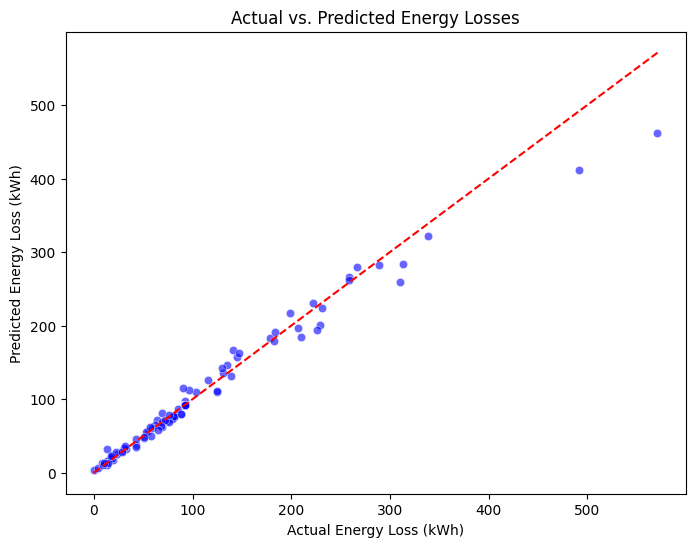

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_tuned, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Perfect prediction line
plt.xlabel("Actual Energy Loss (kWh)")
plt.ylabel("Predicted Energy Loss (kWh)")
plt.title("Actual vs. Predicted Energy Losses")
plt.show()

<ipython-input-27-5efce6baf92d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_indices], y=[feature_names[i] for i in sorted_indices], palette="viridis")


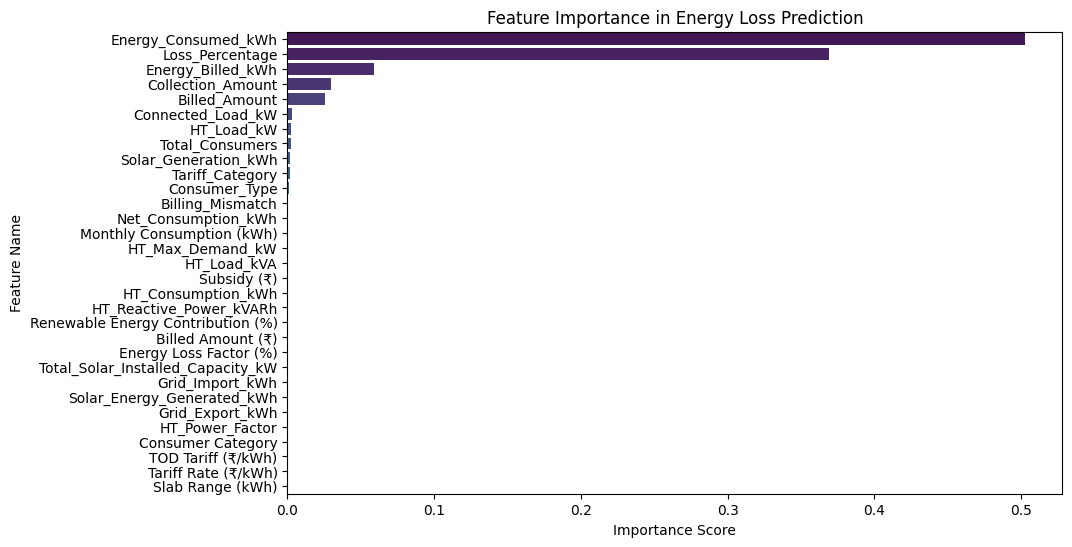

In [ ]:
# Get feature importances
importances = best_rf.feature_importances_
feature_names = X_train.columns

# Sort feature importance values
sorted_indices = importances.argsort()[::-1]

# Bar Chart of Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices], y=[feature_names[i] for i in sorted_indices], palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Energy Loss Prediction")
plt.show()

In [ ]:
# Save the dataset used for training before train-test split
merged_df.to_csv("Final_Processed_Dataset.csv", index=False)
print("Dataset saved as 'Final_Processed_Dataset.csv'")


Dataset saved as 'Final_Processed_Dataset.csv'


In [ ]:
from google.colab import files
files.download("Final_Processed_Dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
# For Colab: upload your merged feeder file
from google.colab import files
uploaded = files.upload()



Saving Unlabeled_Dataset_for_Unsupervised_Learning.csv to Unlabeled_Dataset_for_Unsupervised_Learning.csv


In [ ]:
!pip install pandas scikit-learn
df = pd.read_csv("/content/Final_Processed_Dataset.csv")

# Define features and target variable
# Drop 'Feeder_ID' along with 'Loss_Percentage'
X = df.drop(columns=["Loss_Percentage", "Feeder_ID"])  # Assuming 'Loss_Percentage' is the target and dropping 'Feeder_ID'
y = df["Loss_Percentage"]

# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fix Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# **Apply K-Fold Cross-Validation**
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='r2')

# Train the model
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# **Calculate Accuracy Metrics**
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# **Print Results**
print(f"Training R² Score: {train_r2:.4f}")
print(f"Testing R² Score: {test_r2:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {cv_scores.mean():.4f}")


ValueError: could not convert string to float: '2022-11'

UNSUPERVISED!

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# For Colab: upload your merged feeder file
from google.colab import files
uploaded = files.upload()

In [ ]:
# Load merged feeder data (with labels if any)
df = pd.read_csv("/content/Unlabeled_Dataset_for_Unsupervised_Learning.csv")

# Drop label columns (optional)
label_cols = [
    "Energy_Billed_kWh", "Billed_Amount", "Collection_Amount",
    "Losses_kWh", "Loss_Percentage", "Billing_Mismatch",
    "Billed Consumers", "Billed Load"
]
df_cleaned = df.drop(columns=[col for col in label_cols if col in df.columns], errors='ignore')

# Keep numeric features
numeric_df = df_cleaned.select_dtypes(include=["number"]).dropna(axis=1, how='all')

In [ ]:
# Fill missing values with mean
imputer = SimpleImputer(strategy="mean")
imputed_data = pd.DataFrame(imputer.fit_transform(numeric_df), columns=numeric_df.columns)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed_data)

In [ ]:
# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
anomaly_labels = iso_forest.fit_predict(scaled_data)  # -1 = anomaly, 1 = normal

# Add results
imputed_data["Anomaly_Flag"] = anomaly_labels


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10,6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=imputed_data["Anomaly_Flag"], palette={1: 'green', -1: 'red'})
plt.title("Anomaly Detection with Isolation Forest (PCA View)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()